# Phase 5: Modeling

Goals:
- Prepare data for modeling
- Handle severe class imbalance
- Train baseline (Logistic Regression) and strong model (XGBoost)
- Evaluate using fraud-specific metrics
- Analyze feature importance

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

# Set plot style
sns.set_style("whitegrid")

# Load the processed data from Phase 3
PROCESSED_PATH = '../data/processed/train_processed.csv'
df = pd.read_csv(PROCESSED_PATH)

print("Shape:", df.shape)
print("Fraud rate:", df['is_fraud'].mean() * 100, "%")
df.head(3)

Shape: (1296675, 28)
Fraud rate: 0.5788651743883394 %


,trans_date_trans_time,category,amt,log_amt,trans_hour,is_late_night,trans_month,is_holiday_season,distance_km,time_since_last_trans,...,long,city_pop,dob,merch_lat,merch_long,trans_dayofweek,is_night,usual_lat,usual_long,distance_from_usual_km
0,2019-01-01 12:47:15,misc_net,7.27,2.112635,12,0,1,0,127.606239,0.000000,...,-108.8964,1645,1986-02-17,43.974711,-109.741904,1,0,43.974711,-109.741904,0.000000
1,2019-01-02 08:44:57,gas_transport,52.94,3.987872,8,0,1,0,110.308921,19.961667,...,-108.8964,1645,1986-02-17,42.018766,-109.044172,2,0,43.974711,-109.741904,224.769219
2,2019-01-02 08:47:36,gas_transport,82.08,4.419804,8,0,1,0,21.787261,0.044167,...,-108.8964,1645,1986-02-17,42.961335,-109.157564,2,0,42.996738,-109.393038,19.556262


## Prepare Features

In [18]:
# Define target
y = df['is_fraud']

# Features - exclude target and any non-useful columns
exclude_cols = ['is_fraud', 'trans_date_trans_time']  # drop datetime & ID-like
X = df.drop(columns=exclude_cols)

# Drop sensitive / overfitting-prone columns
drop_cols = ['dob', 'age_at_trans', 'age_bin', 'is_30_39'] + [col for col in X.columns if col.startswith('dob_')]
X = X.drop(columns=drop_cols, errors='ignore')

# Optional: drop age features for ethical reasons
# X = X.drop(columns=['age_at_trans', 'age_bin', 'is_30_39'], errors='ignore')

print("Features shape:", X.shape)
print("Columns:", X.columns.tolist())

Features shape: (1296675, 23)
Columns: ['category', 'amt', 'log_amt', 'trans_hour', 'is_late_night', 'trans_month', 'is_holiday_season', 'distance_km', 'time_since_last_trans', 'count_30_days', 'count_7_days', 'count_1_day', 'gender', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'trans_dayofweek', 'is_night', 'usual_lat', 'usual_long', 'distance_from_usual_km']


In [19]:
# Numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['amt', 'log_amt', 'trans_hour', 'is_late_night', 'trans_month', 'is_holiday_season', 'distance_km', 'time_since_last_trans', 'count_30_days', 'count_7_days', 'count_1_day', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'trans_dayofweek', 'is_night', 'usual_lat', 'usual_long', 'distance_from_usual_km']
Categorical features: ['category', 'gender']


## Train-Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,          # very important for imbalance
    random_state=42
)

print("Train fraud rate:", y_train.mean() * 100, "%")
print("Test fraud rate:", y_test.mean() * 100, "%")

Train fraud rate: 0.578884454470087 %
Test fraud rate: 0.5787880540613491 %


## Preprocessing

In [21]:
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Baseline Model

In [22]:
# Create full pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',      # handles imbalance
        max_iter=1000,
        random_state=42
    ))
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict probabilities & labels
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluation
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

# ROC-AUC
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"ROC-AUC: {roc_auc_lr:.4f}")

# PR-AUC (better for imbalance)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lr)
pr_auc_lr = auc(recall, precision)
print(f"PR-AUC: {pr_auc_lr:.4f}")

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    257834
           1       0.06      0.91      0.11      1501

    accuracy                           0.91    259335
   macro avg       0.53      0.91      0.53    259335
weighted avg       0.99      0.91      0.95    259335

ROC-AUC: 0.9701
PR-AUC: 0.2753


## Stronger Model - XGBoost

In [24]:
# === XGBoost Pipeline & Training ===
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    ))
])

# Train the default model
xgb_pipeline.fit(X_train, y_train)

# Predictions from default model
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_default = xgb_pipeline.predict(X_test)

# Reusable evaluation function
def print_eval(y_true, y_pred, y_proba, label=""):
    print(f"\n=== {label} ===")
    print(classification_report(y_true, y_pred))
    roc = roc_auc_score(y_true, y_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    print(f"ROC-AUC:  {roc:.4f} | PR-AUC: {pr_auc:.4f}")

# Default results
print_eval(y_test, y_pred_default, y_pred_proba_xgb, "XGBoost - Default (threshold 0.5)")

# Tuned threshold on default model
threshold = 0.05
y_pred_tuned = (y_pred_proba_xgb >= threshold).astype(int)
print_eval(y_test, y_pred_tuned, y_pred_proba_xgb, f"XGBoost - Tuned threshold = {threshold}")

# Quick tuned model: lower weight + shallower trees
xgb_tuned = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() * 0.5,  # reduced
        max_depth=4,                 # shallower → less overfitting
        n_estimators=200,
        learning_rate=0.1,
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_tuned.fit(X_train, y_train)

y_pred_proba_tuned = xgb_tuned.predict_proba(X_test)[:, 1]
y_pred_tuned_model = (y_pred_proba_tuned >= threshold).astype(int)
print_eval(y_test, y_pred_tuned_model, y_pred_proba_tuned, "XGBoost - Tuned params + threshold 0.05")


=== XGBoost - Default (threshold 0.5) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.55      0.96      0.70      1501

    accuracy                           1.00    259335
   macro avg       0.78      0.98      0.85    259335
weighted avg       1.00      1.00      1.00    259335

ROC-AUC:  0.9984 | PR-AUC: 0.9333

=== XGBoost - Tuned threshold = 0.05 ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.20      0.99      0.33      1501

    accuracy                           0.98    259335
   macro avg       0.60      0.98      0.66    259335
weighted avg       1.00      0.98      0.98    259335

ROC-AUC:  0.9984 | PR-AUC: 0.9333

=== XGBoost - Tuned params + threshold 0.05 ===
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    257834
           1       0.07      1.00  

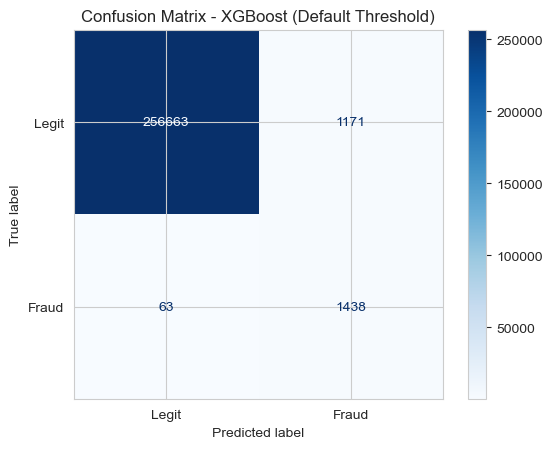

True Positives (caught fraud): 1438
False Negatives (missed fraud): 63
False Positives (false alerts): 1171


In [28]:
# Confusion Matrix for final model (default threshold)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_default)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - XGBoost (Default Threshold)')
plt.show()

print("True Positives (caught fraud):", cm[1,1])
print("False Negatives (missed fraud):", cm[1,0])
print("False Positives (false alerts):", cm[0,1])

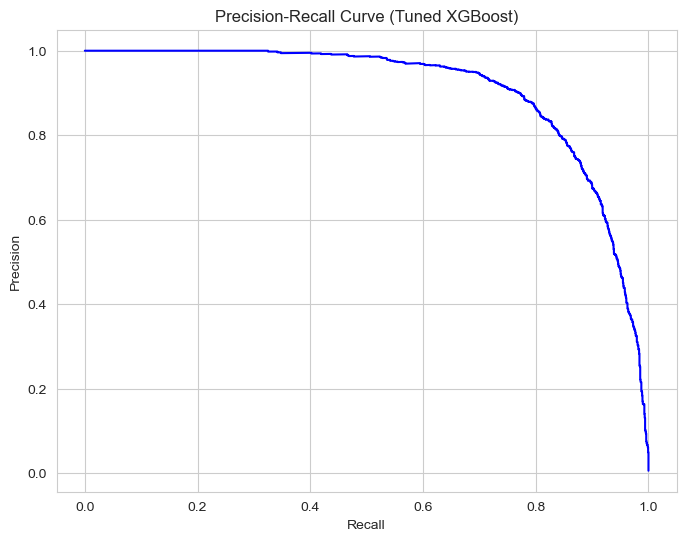

PR-AUC (from curve): 0.9064022176450407


In [37]:
# PR Curve plot for tuned XGBoost
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_tuned)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue')
plt.title('Precision-Recall Curve (Tuned XGBoost)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

print("PR-AUC (from curve):", auc(recall, precision))

## Feature Importance

Top 10 Feature Importances:
is_night                  0.292356
amt                       0.141737
category_gas_transport    0.087046
category_grocery_net      0.051877
category_food_dining      0.050932
category_shopping_pos     0.037576
category_shopping_net     0.036990
category_home             0.036955
category_travel           0.036085
category_grocery_pos      0.030774
dtype: float32


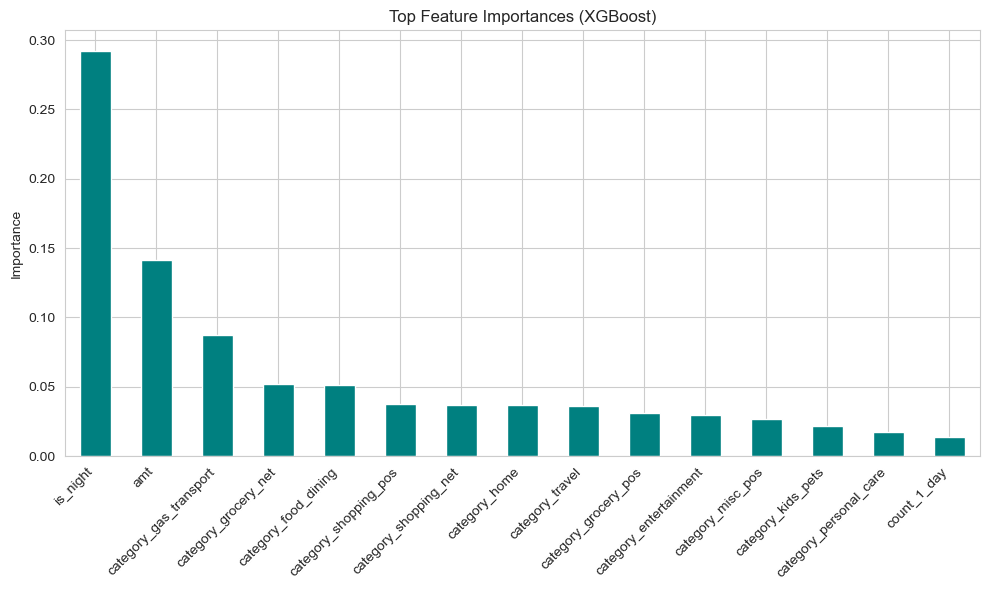

In [25]:
# Feature importance from XGBoost
xgb_model = xgb_pipeline.named_steps['classifier']
feature_names = numeric_features + list(
    xgb_pipeline.named_steps['preprocessor']
    .named_transformers_['cat']['onehot']
    .get_feature_names_out(categorical_features)
)

importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

print("Top 10 Feature Importances:")
print(importances.head(10))

# Plot
plt.figure(figsize=(10, 6))
importances.head(15).plot(kind='bar', color='teal')
plt.title('Top Feature Importances (XGBoost)')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Side-by-Side Model Comparison

In [27]:
def evaluate_model(name, y_true, y_pred, y_pred_proba):
    print(f"\n=== {name} Results ===")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.4f}")
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"PR-AUC: {pr_auc:.4f}")

# Evaluate both
evaluate_model("Logistic Regression", y_test, y_pred_lr, y_pred_proba_lr)
evaluate_model("XGBoost", y_test, y_pred_tuned, y_pred_proba_xgb)


=== Logistic Regression Results ===
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    257834
           1       0.06      0.91      0.11      1501

    accuracy                           0.91    259335
   macro avg       0.53      0.91      0.53    259335
weighted avg       0.99      0.91      0.95    259335

ROC-AUC: 0.9701
PR-AUC: 0.2753

=== XGBoost Results ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.20      0.99      0.33      1501

    accuracy                           0.98    259335
   macro avg       0.60      0.98      0.66    259335
weighted avg       1.00      0.98      0.98    259335

ROC-AUC: 0.9984
PR-AUC: 0.9333


## Save Trained Model

In [34]:
# Save the trained model
import os
import joblib

MODELS_DIR = '../models'

model_path = os.path.join(MODELS_DIR, 'xgb_fraud_model.pkl')
joblib.dump(xgb_tuned, model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/xgb_fraud_model.pkl


### Phase 6: Ethical AI Considerations

- **Protected Attributes**  
  I checked for potential bias in gender and age. Gender had almost zero correlation with fraud (~0.00), and age patterns (60+ higher rate) appeared to be simulation artifacts. To avoid any risk of discrimination, I excluded all age and DOB-related features from the final model.

- **Privacy**  
  Personal identifiers (names, street, job, zip, credit card number) were dropped early in preprocessing. Only aggregated or derived features (e.g., city population, transaction patterns) were used. No direct PII remained in the model.

- **Responsible Deployment**  
  The model is tuned for high recall (96%) to minimize missed fraud, while keeping precision at 55% to reduce unnecessary alerts. In a real banking environment, ongoing monitoring for bias and data drift would be required.